# Packages and Data loading

## packages

In [50]:
import numpy as np
import pandas as pd
from pathlib import Path
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
from catboost import CatBoostClassifier, Pool
from sklearn.model_selection import train_test_split, StratifiedKFold, KFold, cross_val_score, GridSearchCV, RepeatedStratifiedKFold
import time
import shap
shap.initjs()

# visualization
import matplotlib.pyplot as plt
import seaborn as sns

## data preparation

### reading (train, test)

In [51]:
PATH_TO_DATA = Path('../jupyter_english/input/flight-delays-fall-2018/')
train_df = pd.read_csv(PATH_TO_DATA / 'flight_delays_train.csv')
train_df.head()

,Month,DayofMonth,DayOfWeek,DepTime,UniqueCarrier,Origin,Dest,Distance,dep_delayed_15min
0,c-8,c-21,c-7,1934,AA,ATL,DFW,732,N
1,c-4,c-20,c-3,1548,US,PIT,MCO,834,N
2,c-9,c-2,c-5,1422,XE,RDU,CLE,416,N
3,c-11,c-25,c-6,1015,OO,DEN,MEM,872,N
4,c-10,c-7,c-6,1828,WN,MDW,OMA,423,Y


In [52]:
test_df = pd.read_csv(PATH_TO_DATA / 'flight_delays_test.csv')
test_df.head()

,Month,DayofMonth,DayOfWeek,DepTime,UniqueCarrier,Origin,Dest,Distance
0,c-7,c-25,c-3,615,YV,MRY,PHX,598
1,c-4,c-17,c-2,739,WN,LAS,HOU,1235
2,c-12,c-2,c-7,651,MQ,GSP,ORD,577
3,c-3,c-25,c-7,1614,WN,BWI,MHT,377
4,c-6,c-6,c-3,1505,UA,ORD,STL,258


### target

In [53]:
# Extract the labels
train_y = train_df.pop('dep_delayed_15min')
train_y = train_y.map({'N': 0, 'Y': 1})


### preprocessing. cat features and types

In [54]:
# Concatenate for preprocessing
train_split = train_df.shape[0]
full_df = pd.concat((train_df, test_df))
full_df['Distance'] = np.log(full_df['Distance'])

full_df['flight'] = full_df['Origin'] + '-->' + full_df['Dest']

# String to numerical
for col in ['Month', 'DayofMonth', 'DayOfWeek']:
    full_df[col] = full_df[col].apply(lambda x: x.split('-')[1]).astype(np.int32) - 1
    
# Label Encoding
for col in ['Origin', 'Dest', 'UniqueCarrier', 'flight']:
    full_df[col] = pd.factorize(full_df[col])[0]
    
# Categorical columns
cat_cols = ['Month', 'DayofMonth', 'DayOfWeek', 'Origin', 'Dest', 'UniqueCarrier', 'flight']
cat_cols_ind = np.where(train_df.dtypes == 'category')[0]

for c in cat_cols:
    full_df[c] = full_df[c].astype('category')
    
# Split into train and test
train_df, test_df = full_df.iloc[:train_split], full_df.iloc[train_split:]
train_df.shape, train_y.shape, test_df.shape


((100000, 9), (100000,), (100000, 9))

In [55]:
full_df.head()

,Month,DayofMonth,DayOfWeek,DepTime,UniqueCarrier,Origin,Dest,Distance,flight
0,7,20,6,1934,0,0,0,6.595781,0
1,3,19,2,1548,1,1,1,6.726233,1
2,8,1,4,1422,2,2,2,6.030685,2
3,10,24,5,1015,3,3,3,6.770789,3
4,9,6,5,1828,4,4,4,6.047372,4


#  Train Function, Feature Importance Func and First Model

## Training function

In [56]:
def train_model(X, X_test, y, params, folds, model_type='cat', cat_features = [], plot_feature_importance=True, averaging='usual', model=None):
    oof = np.zeros(len(X))
    prediction = np.zeros(len(X_test))
    scores = []
    feature_importance = pd.DataFrame()
    for fold_n, (train_index, valid_index) in enumerate(folds.split(X, y)):
        print('Fold', fold_n, 'started at', time.ctime())
        X_train, X_valid = X.loc[train_index], X.loc[valid_index]
        y_train, y_valid = y[train_index], y[valid_index]
        
        if model_type == 'cat':
            model = CatBoostClassifier(**params)
            model.fit(X_train, 
                      y_train, 
                      eval_set=(X_valid, y_valid), 
                      cat_features=cat_features, 
                      use_best_model=True, 
                      verbose=500)

            y_pred_valid = model.predict_proba(X_valid)[:, 1]
            y_pred = model.predict_proba(X_test)[:, 1]
            
        oof[valid_index] = y_pred_valid.reshape(-1,)
        scores.append(roc_auc_score(y_valid, y_pred_valid))

        if averaging == 'usual':
            prediction += y_pred
        elif averaging == 'rank':
            prediction += pd.Series(y_pred).rank().values  
            
    prediction /= n_fold
    
    print('CV mean score: {0:.4f}, std: {1:.4f}.'.format(np.mean(scores), np.std(scores)))
    
    return oof, prediction, scores, model

## Params

In [57]:
# fast
params_cat = {
    'iterations' : 1000,
    'learning_rate' : 0.05,
    'loss_function':'Logloss',
    'eval_metric':'AUC', 
    'task_type': 'GPU',
    'early_stopping_rounds': 200,
#     'logging_level': 'Info', 
         }

n_fold = 5
folds = StratifiedKFold(n_splits=n_fold, shuffle=True, random_state=42)

# balance
# params_cat = {
#     'iterations' : 20000,
#     'learning_rate' : 0.05,
#     'loss_function':'Logloss',
#     'eval_metric':'AUC', 
#     'task_type': 'GPU',
#     'early_stopping_rounds': 200,
#     'logging_level': 'Info', 
#          }

# best score
# params_cat = {
#     'iterations' : 20000,
#     'learning_rate' : 0.05,
#     'loss_function':'Logloss',
#     'eval_metric':'AUC', 
#     'task_type': 'GPU',
#          }

## Create and train first model

In [58]:
train_df.head()

,Month,DayofMonth,DayOfWeek,DepTime,UniqueCarrier,Origin,Dest,Distance,flight
0,7,20,6,1934,0,0,0,6.595781,0
1,3,19,2,1548,1,1,1,6.726233,1
2,8,1,4,1422,2,2,2,6.030685,2
3,10,24,5,1015,3,3,3,6.770789,3
4,9,6,5,1828,4,4,4,6.047372,4


In [59]:
oof_cat, prediction_cat, scores_cat, cat_model = train_model(train_df,
                                                  test_df,
                                                  train_y,
                                                  params=params_cat,
                                                  cat_features=cat_cols_ind,
                                                  folds=folds,
                                                  model_type='cat',
                                                  plot_feature_importance=True)

Fold 0 started at Tue Nov 12 18:27:50 2019
0:	learn: 0.6679734	test: 0.6655324	best: 0.6655324 (0)	total: 33.2ms	remaining: 33.2s
500:	learn: 0.7686892	test: 0.7349810	best: 0.7349905 (499)	total: 14.5s	remaining: 14.4s
999:	learn: 0.8018456	test: 0.7403678	best: 0.7403678 (999)	total: 28.8s	remaining: 0us
bestTest = 0.7403677702
bestIteration = 999
Fold 1 started at Tue Nov 12 18:28:21 2019
0:	learn: 0.6690496	test: 0.6624749	best: 0.6624749 (0)	total: 31.8ms	remaining: 31.8s
500:	learn: 0.7696682	test: 0.7331084	best: 0.7331084 (500)	total: 14.3s	remaining: 14.2s
999:	learn: 0.8035920	test: 0.7400858	best: 0.7401444 (993)	total: 29s	remaining: 0us
bestTest = 0.740144372
bestIteration = 993
Shrink model to first 994 iterations.
Fold 2 started at Tue Nov 12 18:28:51 2019
0:	learn: 0.6696542	test: 0.6634429	best: 0.6634429 (0)	total: 35.5ms	remaining: 35.5s
500:	learn: 0.7694347	test: 0.7359561	best: 0.7359637 (496)	total: 14.2s	remaining: 14.1s
999:	learn: 0.8027374	test: 0.7412301	bes

## Feature Importance Function

### First way

In [60]:
def feature_importance(model, df_train, y, cat_features):
    feature_score = pd.DataFrame(list(zip(df_train.dtypes.index, model.get_feature_importance(Pool(df_train, label=y, cat_features=cat_features)))),
                columns=['Feature','Score'])
    feature_score = feature_score.sort_values(by='Score', ascending=False, inplace=False, kind='quicksort', na_position='last')
    
    plt.rcParams["figure.figsize"] = (12,7)
    ax = feature_score.plot('Feature', 'Score', kind='bar', color='r')
    ax.set_title("Catboost Feature Importance Ranking", fontsize = 14)
    ax.set_xlabel('')

    rects = ax.patches

    labels = feature_score['Score'].round(2)

    for rect, label in zip(rects, labels):
        height = rect.get_height()
        ax.text(rect.get_x() + rect.get_width()/2, height + 0.35, label, ha='center', va='bottom')

    plt.show()

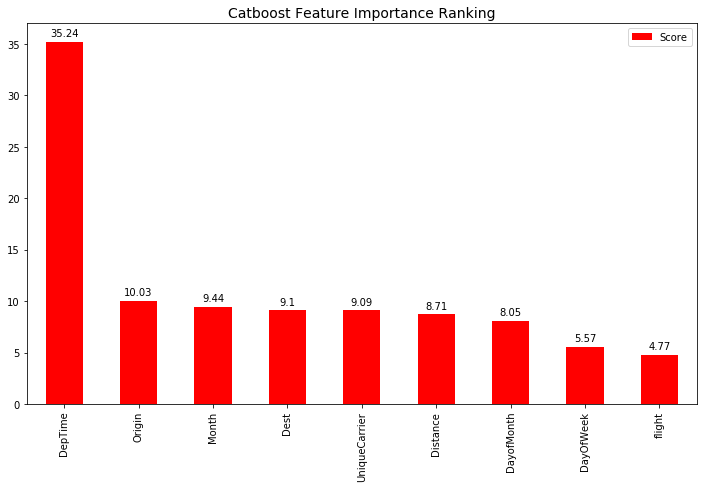

In [61]:
feature_importance(cat_model, train_df, train_y, cat_cols_ind)

### Second way

In [62]:
def feature_importance_sns(model, df_train, y, cat_features, figSize = (16,12)):
    feature_score = pd.DataFrame(list(zip(df_train.dtypes.index, model.get_feature_importance(Pool(df_train, label=y, cat_features=cat_features)))),
                    columns=['Feature','Score'])
    feature_score = feature_score.sort_values(by='Score', ascending=False, inplace=False, kind='quicksort', na_position='last')
    plt.figure(figsize=figSize);
    sns.barplot(x="Score", y="Feature", data=feature_score);
    plt.title('CatBoost Features');

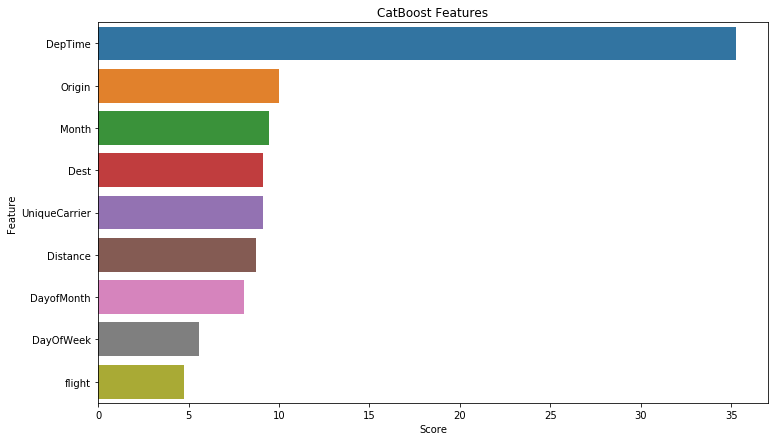

In [63]:
feature_importance_sns(cat_model, train_df, train_y, cat_cols_ind, figSize = (12,7))

# EDA and Feature Enginering

## EDA

## Ad more features

In [64]:
full_df.head()

,Month,DayofMonth,DayOfWeek,DepTime,UniqueCarrier,Origin,Dest,Distance,flight
0,7,20,6,1934,0,0,0,6.595781,0
1,3,19,2,1548,1,1,1,6.726233,1
2,8,1,4,1422,2,2,2,6.030685,2
3,10,24,5,1015,3,3,3,6.770789,3
4,9,6,5,1828,4,4,4,6.047372,4


In [65]:
# Hour and minute
full_df['hour'] = full_df['DepTime'] // 100
full_df.loc[full_df['hour'] == 24, 'hour'] = 0
full_df.loc[full_df['hour'] == 25, 'hour'] = 1
full_df['minute'] = full_df['DepTime'] % 100

# Season
full_df['summer'] = (full_df['Month'].isin([6, 7, 8])).astype(np.int32)
full_df['autumn'] = (full_df['Month'].isin([9, 10, 11])).astype(np.int32)
full_df['winter'] = (full_df['Month'].isin([12, 1, 2])).astype(np.int32)
full_df['spring'] = (full_df['Month'].isin([3, 4, 5])).astype(np.int32)

# Daytime
full_df['daytime'] = pd.cut(full_df['hour'], bins=[0, 6, 12, 18, 23], include_lowest=True)

# Categorical columns
cat_cols = ['Month', 'DayofMonth', 'DayOfWeek', 'Origin', 'Dest', 'UniqueCarrier', 
            'hour', 'summer', 'autumn', 'winter', 'spring', 'daytime', 'flight']


# Converting categorical columns to type 'category' as required by LGBM
for c in cat_cols:
    full_df[c] = full_df[c].astype('category')

# train and test
train_df, test_df = full_df.iloc[:train_split], full_df.iloc[train_split:]

In [75]:
categ_feat_idx = np.where(train_df.dtypes == 'category')[0]
train_df.dtypes

Month            category
DayofMonth       category
DayOfWeek        category
DepTime             int64
UniqueCarrier    category
Origin           category
Dest             category
Distance          float64
flight           category
hour             category
minute              int64
summer           category
autumn           category
winter           category
spring           category
daytime          category
dtype: object

## Train with this features and SKF, check result

### SKF

In [76]:
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=13)
former_feats = ['Month', 'DayofMonth', 'DayOfWeek', 'DepTime', 'UniqueCarrier', 
                'Origin', 'Dest', 'Distance', 'flight']
new_feats = ['hour', 'minute', 'summer', 'autumn', 'winter', 'spring', 'daytime']

In [77]:
%%time
ctb = CatBoostClassifier(task_type='GPU', random_seed=13, silent=True)
features_to_use = former_feats[:]
initial_cv_scores = cross_val_score(ctb, train_df[features_to_use].values, train_y, cv=skf, scoring='roc_auc', 
                fit_params={'cat_features': np.where(train_df[features_to_use].dtypes == 'category')[0]})
initial_cv_scores, initial_cv_scores.mean()

Learning rate set to 0.057902
0:	learn: 0.6612116	total: 120ms	remaining: 2m
1:	learn: 0.6345654	total: 229ms	remaining: 1m 54s
2:	learn: 0.6104875	total: 348ms	remaining: 1m 55s
3:	learn: 0.5900857	total: 447ms	remaining: 1m 51s
4:	learn: 0.5720253	total: 549ms	remaining: 1m 49s
5:	learn: 0.5555706	total: 658ms	remaining: 1m 49s
6:	learn: 0.5415976	total: 763ms	remaining: 1m 48s
7:	learn: 0.5292762	total: 872ms	remaining: 1m 48s
8:	learn: 0.5189157	total: 973ms	remaining: 1m 47s
9:	learn: 0.5095867	total: 1.08s	remaining: 1m 46s
10:	learn: 0.5022217	total: 1.18s	remaining: 1m 46s
11:	learn: 0.4947331	total: 1.3s	remaining: 1m 46s
12:	learn: 0.4885515	total: 1.4s	remaining: 1m 46s
13:	learn: 0.4829275	total: 1.51s	remaining: 1m 46s
14:	learn: 0.4784909	total: 1.6s	remaining: 1m 45s
15:	learn: 0.4739169	total: 1.71s	remaining: 1m 44s
16:	learn: 0.4698161	total: 1.79s	remaining: 1m 43s
17:	learn: 0.4665287	total: 1.89s	remaining: 1m 43s
18:	learn: 0.4632853	total: 2s	remaining: 1m 43s
19

157:	learn: 0.4150621	total: 15.8s	remaining: 1m 24s
158:	learn: 0.4149978	total: 15.9s	remaining: 1m 24s
159:	learn: 0.4148857	total: 16.1s	remaining: 1m 24s
160:	learn: 0.4148029	total: 16.2s	remaining: 1m 24s
161:	learn: 0.4147417	total: 16.2s	remaining: 1m 23s
162:	learn: 0.4147073	total: 16.3s	remaining: 1m 23s
163:	learn: 0.4146621	total: 16.4s	remaining: 1m 23s
164:	learn: 0.4145743	total: 16.5s	remaining: 1m 23s
165:	learn: 0.4145025	total: 16.6s	remaining: 1m 23s
166:	learn: 0.4144246	total: 16.7s	remaining: 1m 23s
167:	learn: 0.4143127	total: 16.8s	remaining: 1m 23s
168:	learn: 0.4142463	total: 16.9s	remaining: 1m 23s
169:	learn: 0.4141495	total: 17s	remaining: 1m 23s
170:	learn: 0.4140937	total: 17.2s	remaining: 1m 23s
171:	learn: 0.4140301	total: 17.2s	remaining: 1m 23s
172:	learn: 0.4139936	total: 17.4s	remaining: 1m 22s
173:	learn: 0.4138813	total: 17.4s	remaining: 1m 22s
174:	learn: 0.4138033	total: 17.5s	remaining: 1m 22s
175:	learn: 0.4137667	total: 17.6s	remaining: 1m

313:	learn: 0.4069812	total: 30.3s	remaining: 1m 6s
314:	learn: 0.4069508	total: 30.4s	remaining: 1m 6s
315:	learn: 0.4068928	total: 30.5s	remaining: 1m 6s
316:	learn: 0.4068469	total: 30.6s	remaining: 1m 5s
317:	learn: 0.4068201	total: 30.7s	remaining: 1m 5s
318:	learn: 0.4067585	total: 30.8s	remaining: 1m 5s
319:	learn: 0.4067169	total: 30.9s	remaining: 1m 5s
320:	learn: 0.4066819	total: 31s	remaining: 1m 5s
321:	learn: 0.4066575	total: 31.1s	remaining: 1m 5s
322:	learn: 0.4066098	total: 31.1s	remaining: 1m 5s
323:	learn: 0.4065551	total: 31.2s	remaining: 1m 5s
324:	learn: 0.4064970	total: 31.3s	remaining: 1m 5s
325:	learn: 0.4064599	total: 31.4s	remaining: 1m 4s
326:	learn: 0.4064286	total: 31.5s	remaining: 1m 4s
327:	learn: 0.4064047	total: 31.6s	remaining: 1m 4s
328:	learn: 0.4063716	total: 31.7s	remaining: 1m 4s
329:	learn: 0.4063226	total: 31.8s	remaining: 1m 4s
330:	learn: 0.4062865	total: 31.9s	remaining: 1m 4s
331:	learn: 0.4062666	total: 32s	remaining: 1m 4s
332:	learn: 0.40

472:	learn: 0.4005842	total: 44.9s	remaining: 50s
473:	learn: 0.4005526	total: 44.9s	remaining: 49.9s
474:	learn: 0.4005338	total: 45s	remaining: 49.8s
475:	learn: 0.4005147	total: 45.1s	remaining: 49.7s
476:	learn: 0.4004645	total: 45.2s	remaining: 49.6s
477:	learn: 0.4004297	total: 45.3s	remaining: 49.5s
478:	learn: 0.4003694	total: 45.4s	remaining: 49.4s
479:	learn: 0.4003395	total: 45.5s	remaining: 49.3s
480:	learn: 0.4003104	total: 45.6s	remaining: 49.2s
481:	learn: 0.4002983	total: 45.7s	remaining: 49.1s
482:	learn: 0.4002521	total: 45.8s	remaining: 49s
483:	learn: 0.4002195	total: 45.9s	remaining: 48.9s
484:	learn: 0.4001721	total: 46s	remaining: 48.8s
485:	learn: 0.4001109	total: 46.1s	remaining: 48.7s
486:	learn: 0.4000565	total: 46.2s	remaining: 48.6s
487:	learn: 0.4000461	total: 46.2s	remaining: 48.5s
488:	learn: 0.4000070	total: 46.3s	remaining: 48.4s
489:	learn: 0.3999930	total: 46.4s	remaining: 48.3s
490:	learn: 0.3999728	total: 46.5s	remaining: 48.2s
491:	learn: 0.399936

631:	learn: 0.3942436	total: 59.4s	remaining: 34.6s
632:	learn: 0.3942055	total: 59.5s	remaining: 34.5s
633:	learn: 0.3941721	total: 59.7s	remaining: 34.4s
634:	learn: 0.3941433	total: 59.8s	remaining: 34.4s
635:	learn: 0.3941048	total: 59.9s	remaining: 34.3s
636:	learn: 0.3940613	total: 60s	remaining: 34.2s
637:	learn: 0.3940320	total: 1m	remaining: 34.1s
638:	learn: 0.3939846	total: 1m	remaining: 34s
639:	learn: 0.3939553	total: 1m	remaining: 33.9s
640:	learn: 0.3939179	total: 1m	remaining: 33.8s
641:	learn: 0.3938982	total: 1m	remaining: 33.7s
642:	learn: 0.3938736	total: 1m	remaining: 33.6s
643:	learn: 0.3938339	total: 1m	remaining: 33.5s
644:	learn: 0.3937746	total: 1m	remaining: 33.4s
645:	learn: 0.3937456	total: 1m	remaining: 33.3s
646:	learn: 0.3937132	total: 1m	remaining: 33.2s
647:	learn: 0.3936649	total: 1m 1s	remaining: 33.1s
648:	learn: 0.3936196	total: 1m 1s	remaining: 33s
649:	learn: 0.3935958	total: 1m 1s	remaining: 32.9s
650:	learn: 0.3935471	total: 1m 1s	remaining: 32

789:	learn: 0.3887521	total: 1m 14s	remaining: 19.7s
790:	learn: 0.3887255	total: 1m 14s	remaining: 19.6s
791:	learn: 0.3886907	total: 1m 14s	remaining: 19.5s
792:	learn: 0.3886502	total: 1m 14s	remaining: 19.4s
793:	learn: 0.3886251	total: 1m 14s	remaining: 19.4s
794:	learn: 0.3885890	total: 1m 14s	remaining: 19.3s
795:	learn: 0.3885199	total: 1m 14s	remaining: 19.2s
796:	learn: 0.3884937	total: 1m 14s	remaining: 19.1s
797:	learn: 0.3884615	total: 1m 14s	remaining: 19s
798:	learn: 0.3884294	total: 1m 15s	remaining: 18.9s
799:	learn: 0.3883939	total: 1m 15s	remaining: 18.8s
800:	learn: 0.3883607	total: 1m 15s	remaining: 18.7s
801:	learn: 0.3882475	total: 1m 15s	remaining: 18.6s
802:	learn: 0.3882094	total: 1m 15s	remaining: 18.5s
803:	learn: 0.3881961	total: 1m 15s	remaining: 18.4s
804:	learn: 0.3881663	total: 1m 15s	remaining: 18.3s
805:	learn: 0.3881322	total: 1m 15s	remaining: 18.2s
806:	learn: 0.3880805	total: 1m 15s	remaining: 18.1s
807:	learn: 0.3880493	total: 1m 15s	remaining: 1

945:	learn: 0.3832936	total: 1m 28s	remaining: 5.05s
946:	learn: 0.3832627	total: 1m 28s	remaining: 4.96s
947:	learn: 0.3832237	total: 1m 28s	remaining: 4.86s
948:	learn: 0.3831874	total: 1m 28s	remaining: 4.77s
949:	learn: 0.3831428	total: 1m 28s	remaining: 4.68s
950:	learn: 0.3831129	total: 1m 28s	remaining: 4.58s
951:	learn: 0.3830891	total: 1m 29s	remaining: 4.49s
952:	learn: 0.3830541	total: 1m 29s	remaining: 4.4s
953:	learn: 0.3830407	total: 1m 29s	remaining: 4.3s
954:	learn: 0.3829918	total: 1m 29s	remaining: 4.21s
955:	learn: 0.3829691	total: 1m 29s	remaining: 4.11s
956:	learn: 0.3829295	total: 1m 29s	remaining: 4.02s
957:	learn: 0.3828851	total: 1m 29s	remaining: 3.93s
958:	learn: 0.3828274	total: 1m 29s	remaining: 3.83s
959:	learn: 0.3828125	total: 1m 29s	remaining: 3.74s
960:	learn: 0.3827677	total: 1m 29s	remaining: 3.65s
961:	learn: 0.3827469	total: 1m 29s	remaining: 3.55s
962:	learn: 0.3827185	total: 1m 30s	remaining: 3.46s
963:	learn: 0.3826826	total: 1m 30s	remaining: 3

102:	learn: 0.4199181	total: 10.5s	remaining: 1m 31s
103:	learn: 0.4198228	total: 10.5s	remaining: 1m 30s
104:	learn: 0.4197534	total: 10.6s	remaining: 1m 30s
105:	learn: 0.4195500	total: 10.7s	remaining: 1m 30s
106:	learn: 0.4194420	total: 10.8s	remaining: 1m 30s
107:	learn: 0.4193625	total: 10.9s	remaining: 1m 30s
108:	learn: 0.4191583	total: 11s	remaining: 1m 30s
109:	learn: 0.4190943	total: 11.1s	remaining: 1m 29s
110:	learn: 0.4189993	total: 11.2s	remaining: 1m 29s
111:	learn: 0.4189106	total: 11.3s	remaining: 1m 29s
112:	learn: 0.4188713	total: 11.4s	remaining: 1m 29s
113:	learn: 0.4187831	total: 11.5s	remaining: 1m 29s
114:	learn: 0.4185898	total: 11.6s	remaining: 1m 29s
115:	learn: 0.4185062	total: 11.7s	remaining: 1m 29s
116:	learn: 0.4184129	total: 11.8s	remaining: 1m 29s
117:	learn: 0.4182919	total: 11.9s	remaining: 1m 28s
118:	learn: 0.4182345	total: 12s	remaining: 1m 28s
119:	learn: 0.4180596	total: 12.1s	remaining: 1m 28s
120:	learn: 0.4178795	total: 12.2s	remaining: 1m 2

258:	learn: 0.4092314	total: 25.1s	remaining: 1m 11s
259:	learn: 0.4091617	total: 25.2s	remaining: 1m 11s
260:	learn: 0.4090984	total: 25.3s	remaining: 1m 11s
261:	learn: 0.4090625	total: 25.4s	remaining: 1m 11s
262:	learn: 0.4090307	total: 25.5s	remaining: 1m 11s
263:	learn: 0.4090001	total: 25.6s	remaining: 1m 11s
264:	learn: 0.4089737	total: 25.7s	remaining: 1m 11s
265:	learn: 0.4089305	total: 25.8s	remaining: 1m 11s
266:	learn: 0.4088975	total: 25.8s	remaining: 1m 10s
267:	learn: 0.4088704	total: 25.9s	remaining: 1m 10s
268:	learn: 0.4088317	total: 26s	remaining: 1m 10s
269:	learn: 0.4088043	total: 26.1s	remaining: 1m 10s
270:	learn: 0.4087571	total: 26.2s	remaining: 1m 10s
271:	learn: 0.4087024	total: 26.3s	remaining: 1m 10s
272:	learn: 0.4086440	total: 26.4s	remaining: 1m 10s
273:	learn: 0.4086173	total: 26.5s	remaining: 1m 10s
274:	learn: 0.4085889	total: 26.5s	remaining: 1m 9s
275:	learn: 0.4085148	total: 26.6s	remaining: 1m 9s
276:	learn: 0.4084883	total: 26.7s	remaining: 1m 9

417:	learn: 0.4021150	total: 39.7s	remaining: 55.3s
418:	learn: 0.4020897	total: 39.8s	remaining: 55.2s
419:	learn: 0.4020503	total: 39.9s	remaining: 55.1s
420:	learn: 0.4019409	total: 40s	remaining: 55s
421:	learn: 0.4019145	total: 40.1s	remaining: 54.9s
422:	learn: 0.4018865	total: 40.1s	remaining: 54.8s
423:	learn: 0.4018515	total: 40.2s	remaining: 54.6s
424:	learn: 0.4017886	total: 40.3s	remaining: 54.5s
425:	learn: 0.4017417	total: 40.4s	remaining: 54.4s
426:	learn: 0.4017095	total: 40.5s	remaining: 54.3s
427:	learn: 0.4016851	total: 40.6s	remaining: 54.2s
428:	learn: 0.4016662	total: 40.7s	remaining: 54.1s
429:	learn: 0.4016193	total: 40.8s	remaining: 54s
430:	learn: 0.4015920	total: 40.9s	remaining: 53.9s
431:	learn: 0.4015665	total: 40.9s	remaining: 53.8s
432:	learn: 0.4015144	total: 41s	remaining: 53.7s
433:	learn: 0.4014842	total: 41.1s	remaining: 53.6s
434:	learn: 0.4014527	total: 41.2s	remaining: 53.5s
435:	learn: 0.4014085	total: 41.3s	remaining: 53.4s
436:	learn: 0.401364

576:	learn: 0.3961242	total: 54.2s	remaining: 39.7s
577:	learn: 0.3960969	total: 54.3s	remaining: 39.6s
578:	learn: 0.3960635	total: 54.4s	remaining: 39.5s
579:	learn: 0.3960385	total: 54.5s	remaining: 39.5s
580:	learn: 0.3959797	total: 54.6s	remaining: 39.4s
581:	learn: 0.3959446	total: 54.7s	remaining: 39.3s
582:	learn: 0.3958915	total: 54.8s	remaining: 39.2s
583:	learn: 0.3958232	total: 54.9s	remaining: 39.1s
584:	learn: 0.3957915	total: 55s	remaining: 39s
585:	learn: 0.3957580	total: 55.1s	remaining: 38.9s
586:	learn: 0.3957280	total: 55.2s	remaining: 38.8s
587:	learn: 0.3956807	total: 55.3s	remaining: 38.7s
588:	learn: 0.3956700	total: 55.3s	remaining: 38.6s
589:	learn: 0.3956471	total: 55.4s	remaining: 38.5s
590:	learn: 0.3956118	total: 55.5s	remaining: 38.4s
591:	learn: 0.3955574	total: 55.6s	remaining: 38.3s
592:	learn: 0.3954891	total: 55.7s	remaining: 38.2s
593:	learn: 0.3954652	total: 55.8s	remaining: 38.1s
594:	learn: 0.3954313	total: 55.9s	remaining: 38s
595:	learn: 0.3953

SystemError: <method '_train' of '_catboost._CatBoost' objects> returned a result with an error set

### Сделать функцией, и с графиком добавления фичи? Как вариант

In [ ]:
%%time
cv_scores = []

features_to_use = former_feats[:]

for new_feat in tqdm(new_feats):
    print(f'adding feature {new_feat}')
    
    features_to_use += [new_feat]
    print(f'performing CV with features: {features_to_use}')

    current_cv_scores = cross_val_score(ctb, train_df[features_to_use].values, train_y, cv=skf, scoring='roc_auc', 
                fit_params={'cat_features': np.where(train_df[features_to_use].dtypes == 'category')[0]})
    print('5-fold CV is : {} +/- {}'.format(current_cv_scores.mean().round(4), 
                                            current_cv_scores.std().round(4)))
    cv_scores.append(current_cv_scores)

## Check Importance of New Features

# New model

# Parameter tuning